# Manage non-automatic inputs for pixel mode

This notebook provides tools to manage the inputs that are difficult to preprocess automatically, that come from different sources or require specific processing (like the land-cover or the soil data).

### Load necessary libraries and define paths and functions

In [1]:
import os  # for path exploration
from fnmatch import fnmatch  # for character string comparison
import xarray as xr  # to manage dataset
import rasterio as rio  # to open geotiff files
import numpy as np  # vectorized math
import pandas as pd  # to manage dataframes
import geopandas as gpd  # to manage shapefile crs projections
from rasterio.enums import Resampling  # to resample dataset
import matplotlib.pyplot as plt  # to plot
from matplotlib import rcParams  # plot parameters
from numba import njit, prange

import sys  # system management
currentdir = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, os.path.dirname(currentdir))
from modspa_pixel.config.config import config  # to import config file
from modspa_pixel.preprocessing.input_toolbox import prepare_directories  # to create necessary input directories

# Parameters for matplotlib
plt.style.use('default')
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams.update({'font.size': 15})

@njit(nogil = True, parallel = True)
def convert_lc_values(array: np.ndarray, list_correspondance: np.ndarray) -> np.ndarray:
    """
    Convert land cover values with numba. Takes in a
    land cover numpy 2D array and a numpy list containing
    the new land cover values. Works if original land cover
    values are integers ranging from 1 to the number of
    classes without gaps (i.e: ``values = [1,2,3,4,5,6,7,8,9,10]``).
    
    Uses numba.

    Arguments
    =========

    1. array: ``np.ndarray``
        2D array of original land cover classes
    2. list_correspondance: ``np.ndarray``
        list of same length as the number of classes
        that contains the new value for original class
        of value i at index i-1 (i.e. new value for 
        original class number 8 at index 7)

    Returns
    =======

    1. array: ``np.ndarray``
        modified array, new land cover values
    """
    
    for i in prange(len(array)):
        for j in prange(len(array[0])):
            array[i, j] = list_correspondance[array[i,j]-1]
    
    return array

# Open config file
config_file = currentdir + os.sep + 'config' + os.sep + 'config_modspa.json'

# Open config file and load parameters
config_params = config(config_file)

# Prepare directories
prepare_directories(config_file)

# Land Cover management

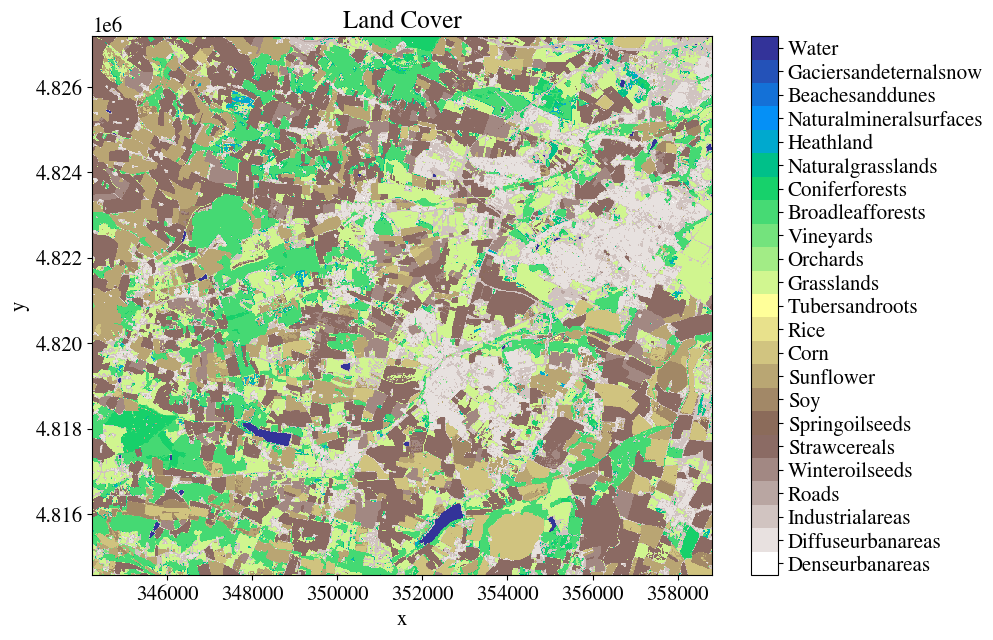

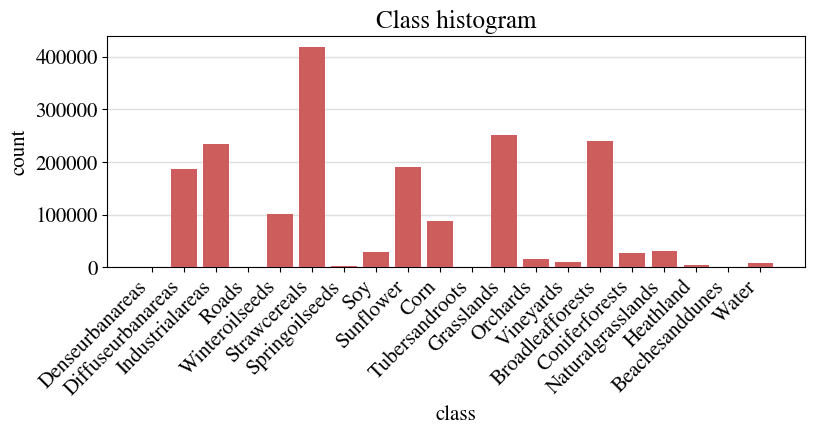

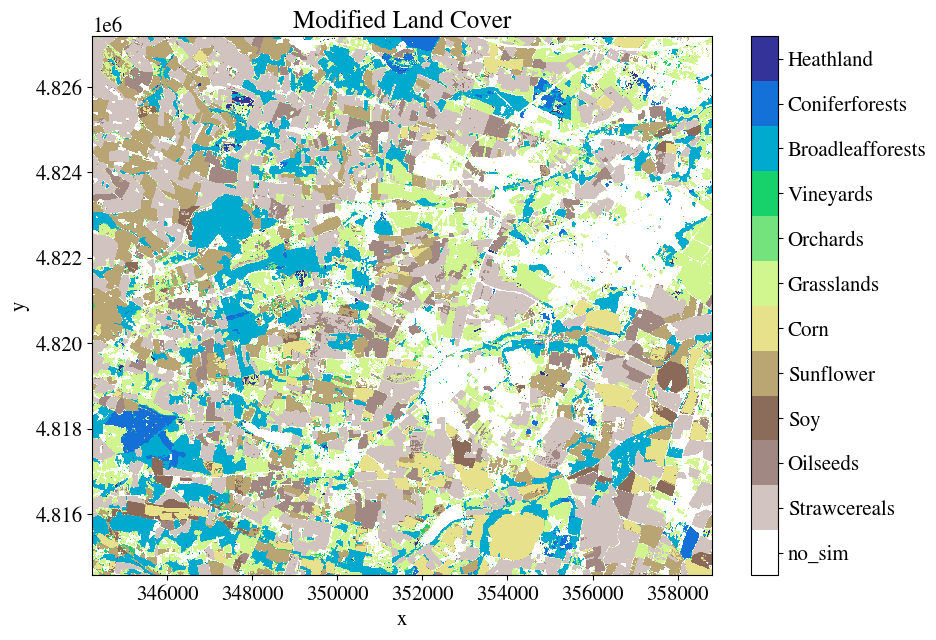

In [2]:
# Path to raw land cover
raw_lc_path = '/mnt/e/DATA/LAND_COVER/Aurade_test/Aurade_test_LC.tif'

# Path to csv conversion file
conversion_csv_file = currentdir + os.sep + 'preprocessing' + os.sep + 'csv_files' + os.sep + 'class_conversion.csv'

# Open and plot land cover raster
landcover = xr.open_dataarray(raw_lc_path).squeeze(dim = ['band'], drop = True).rename('class').astype(np.uint8)

# Open the csv file containing the class convertion information
class_conversion_dataframe = pd.read_csv(conversion_csv_file)

# Get original class names and values
original_classes = class_conversion_dataframe['old_value'].values
class_names = class_conversion_dataframe['old_class'].values

# Plot
cmap = plt.get_cmap('terrain_r', lut = len(original_classes))
plt.figure(figsize = (10,7))
im = landcover.plot.imshow(add_colorbar = False, cmap = cmap, vmin = landcover.min() - 0.5, vmax = landcover.max() + 0.5)
cbar = plt.colorbar(im)
cbar.set_ticks(original_classes)
cbar.set_ticklabels(class_names)
plt.title('Land Cover')

# Get histogram data
flat = landcover.values.reshape(np.prod(landcover.values.shape[:2]),-1)
bins = np.bincount((np.sum(flat, 1)/flat.shape[1]).astype(np.uint8))[1:]
zero_indexes = np.where(bins == 0)[0]  # Get indexes of 0 values
bins = np.delete(bins, zero_indexes)
original_classes_list = [i for i in range(1, len(bins) + 1)]
class_names_hist = np.delete(class_names, zero_indexes)

# Plot histogram
plt.figure(figsize = (9,3))
plt.grid(color='silver', linestyle='-', axis = 'y', linewidth=1, zorder = 1, alpha = 0.5)
plt.bar(original_classes_list, bins, color = 'indianred', zorder = 3)
plt.xticks(original_classes_list, labels = class_names_hist, rotation = 45, ha = 'right')
plt.xlabel('class')
plt.ylabel('count')
plt.title('Class histogram')

# Get sorted new class names and values
new_classes_sorted = class_conversion_dataframe[['new_class', 'new_value']].sort_values(by = 'new_value')
new_class_names = list(dict.fromkeys(new_classes_sorted['new_class'].values))
new_classes = list(dict.fromkeys(new_classes_sorted['new_value'].values))

# Get the class correspondance array
new_class_correspondance = class_conversion_dataframe['new_value'].values

# Create new land cover dataarray
new_landcover = landcover.copy(deep = True)
new_landcover.values = convert_lc_values(new_landcover.values, new_class_correspondance)

# Plot
cmap = plt.get_cmap('terrain_r', lut = len(new_classes))
plt.figure(figsize = (10,7))
im = new_landcover.plot.imshow(add_colorbar = False, cmap = cmap, vmin = new_landcover.min() - 0.5, vmax = new_landcover.max() + 0.5)
cbar = plt.colorbar(im)
cbar.set_ticks(new_classes)
cbar.set_ticklabels(new_class_names)
plt.title('Modified Land Cover');

# Add class names in the land_cover attributes
new_landcover.attrs['class_names'] = new_class_names

# Save new land cover
new_landcover_save_path = config_params.land_cover_path
new_landcover.to_netcdf(new_landcover_save_path, encoding = {"class": {"dtype": "u1"}})

# Soil data management

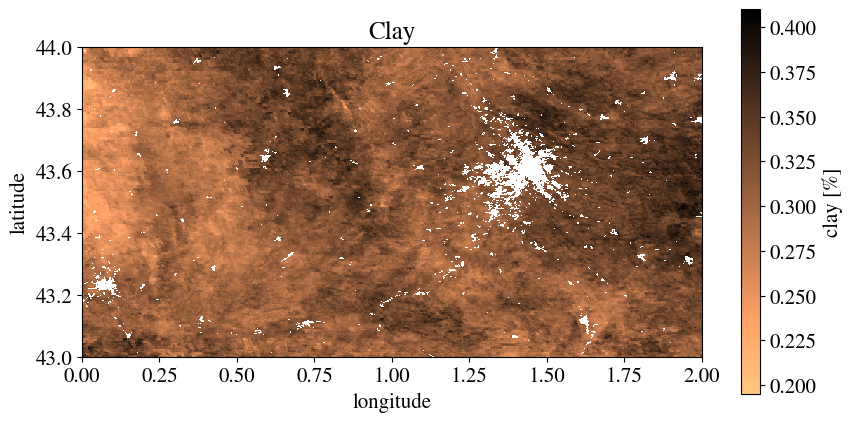

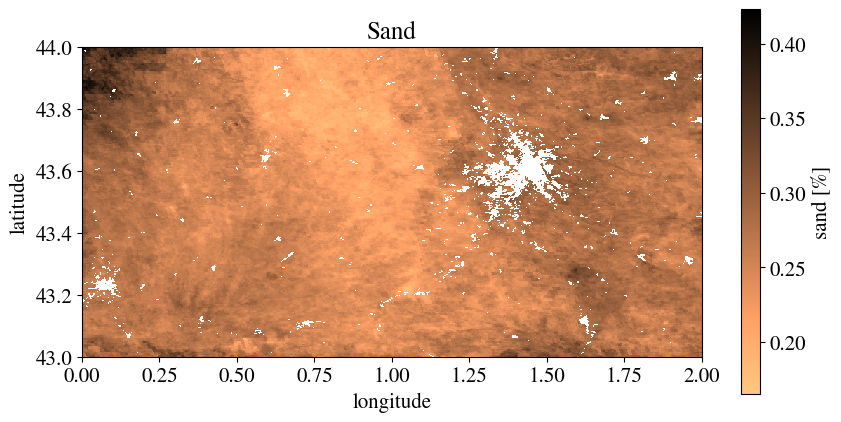

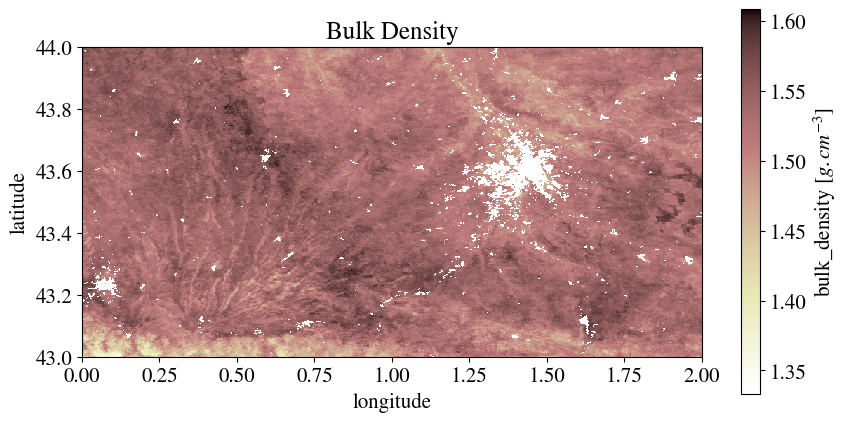

In [3]:
# Path containing the soil files
soil_path = '/mnt/e/DATA/SOIL/Aurade_test'

# Parameters relative to the soil products
depths = [5,15,30,60,100,200]  # depths of each raster
weight_values = [5, 10, 15, 30, 40, 100]  # corresponding weights for mean

# Collect file names
clay_paths = []
sand_paths = []
bd_paths = []
for file in os.listdir(soil_path):
    if fnmatch(file, '*clay*'):
        clay_paths.append(os.path.join(soil_path, file))
    elif fnmatch(file, '*sand*'):
        sand_paths.append(os.path.join(soil_path, file))
    elif fnmatch(file, '*bd*'):
        bd_paths.append(os.path.join(soil_path, file))

# Open clay, sand and bulk density datasets
clay = xr.open_mfdataset(clay_paths, combine = 'nested', concat_dim = 'depth').squeeze(dim = ['band'], drop = True).rename({'band_data': 'clay', 'x': 'longitude', 'y': 'latitude'})
clay = clay.assign_coords(depth=depths)
sand = xr.open_mfdataset(sand_paths, combine = 'nested', concat_dim = 'depth').squeeze(dim = ['band'], drop = True).rename({'band_data': 'sand', 'x': 'longitude', 'y': 'latitude'})
sand = sand.assign_coords(depth=depths)
bd = xr.open_mfdataset(bd_paths, combine = 'nested', concat_dim = 'depth').squeeze(dim = ['band'], drop = True).rename({'band_data': 'bd', 'x': 'longitude', 'y': 'latitude'})
bd = bd.assign_coords(depth=depths)

# Change units
clay = clay / 1000  # from g/kg to %
sand = sand / 1000  # from g/kg to %
bd = bd / 100  # from cg/cm3 to g/cm3

# Set 0 to NaN
clay = xr.where(clay == 0, np.NaN, clay)
sand = xr.where(sand == 0, np.NaN, sand)
bd = xr.where(bd == 0, np.NaN, bd)

# Create weights for the average
weights = xr.DataArray(data = weight_values, coords = {'depth': clay.depth}, dims = 'depth')
weights.name = "weights"

# Parameters for plot
ratio = abs((clay['longitude'].values[-1] - clay['longitude'].values[0])/(clay['latitude'].values[-1] - clay['latitude'].values[0]))
figure_size = (round(ratio*5), 5)

# Apply weighted average, set attributes and plot
fig = plt.figure(figsize = figure_size)
ax = fig.gca()
clay_mean = clay.weighted(weights).mean('depth')
clay_mean.clay.attrs['units'] = '%'
clay_mean.clay.attrs['standard_name'] = 'clay'
clay_mean.clay.plot.imshow(cmap = 'copper_r')
ax.set_aspect('equal', 'box')
plt.title('Clay');

fig = plt.figure(figsize = figure_size)
ax = fig.gca()
sand_mean = sand.weighted(weights).mean('depth')
sand_mean.sand.attrs['units'] = '%'
sand_mean.sand.attrs['standard_name'] = 'sand'
sand_mean.sand.plot.imshow(cmap = 'copper_r')
ax.set_aspect('equal', 'box')
plt.title('Sand');

fig = plt.figure(figsize = figure_size)
ax = fig.gca()
bd_mean = bd.weighted(weights).mean('depth')
bd_mean.bd.attrs['units'] = '$g.cm^{-3}$'
bd_mean.bd.attrs['standard_name'] = 'bulk_density'
bd_mean.bd.plot.imshow(cmap = 'pink_r')
ax.set_aspect('equal', 'box')
plt.title('Bulk Density');

# Apply pedotransfert functions to get wilting point and field capacity

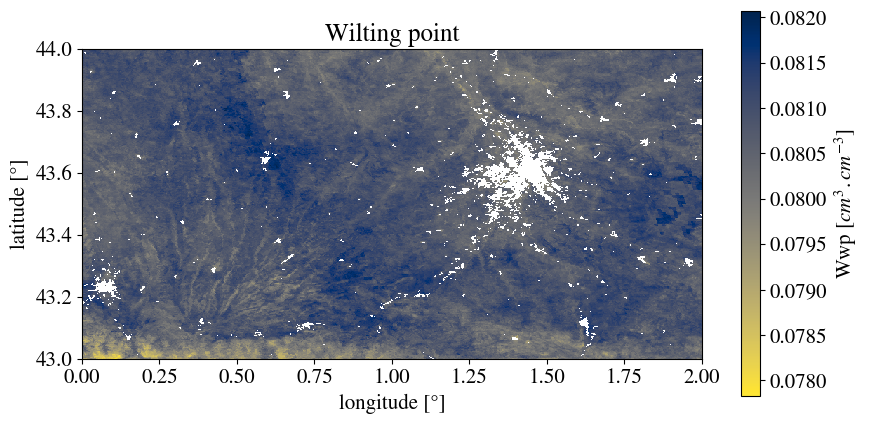

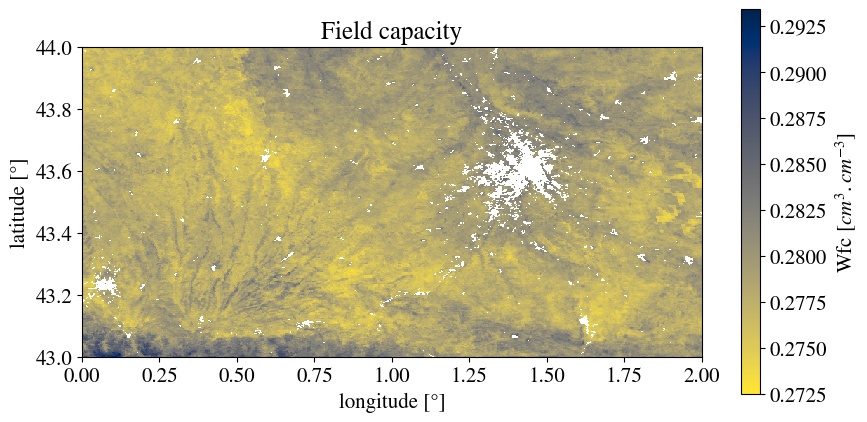

In [4]:
# Coefficients
capacity_coeffs = [0.394, 2.29e-3, -1.24e-3, -7.58e-2]
wilting_coeffs = [0.056, 4.06e-3, -3.14e-4, 1.54e-2]

# Create empty dataset
soil_params = clay_mean.copy(deep = True).drop_vars(['clay'])

# Create new variables from pedotransfert functions
soil_params['Wwp'] = wilting_coeffs[0] + wilting_coeffs[1] * clay_mean.clay + wilting_coeffs[2] * sand_mean.sand + wilting_coeffs[3] * bd_mean.bd
soil_params['Wfc'] = capacity_coeffs[0] + capacity_coeffs[1] * clay_mean.clay + capacity_coeffs[2] * sand_mean.sand + capacity_coeffs[3] * bd_mean.bd

# Setting attributes
soil_params['longitude'].attrs['standard_name'] = 'longitude'
soil_params['longitude'].attrs['units'] = '°'
soil_params['latitude'].attrs['standard_name'] = 'latitude'
soil_params['latitude'].attrs['units'] = '°'

soil_params.Wwp.attrs['name'] = 'wilting_point'
soil_params.Wwp.attrs['units'] = '$cm^{3}.cm^{-3}$'

soil_params.Wfc.attrs['name'] = 'field_capacity'
soil_params.Wfc.attrs['units'] = '$cm^{3}.cm^{-3}$'

# Parameters for plot
ratio = abs((soil_params['longitude'].values[-1] - soil_params['longitude'].values[0])/(soil_params['latitude'].values[-1] - soil_params['latitude'].values[0]))
figure_size = (round(ratio*5), 5)

# Plot variables
fig = plt.figure(figsize = figure_size)
ax = fig.gca()
soil_params.Wwp.plot.imshow(cmap = 'cividis_r')
ax.set_aspect('equal', 'box')
plt.title('Wilting point');

fig = plt.figure(figsize = figure_size)
ax = fig.gca()
soil_params.Wfc.plot.imshow(cmap = 'cividis_r')
ax.set_aspect('equal', 'box')
plt.title('Field capacity');

# Save low resolution dataset
original_save_path = soil_path + os.sep + 'Soil_low_resolution.nc'
soil_params.to_netcdf(original_save_path)

# Apply reprojection on the input grid

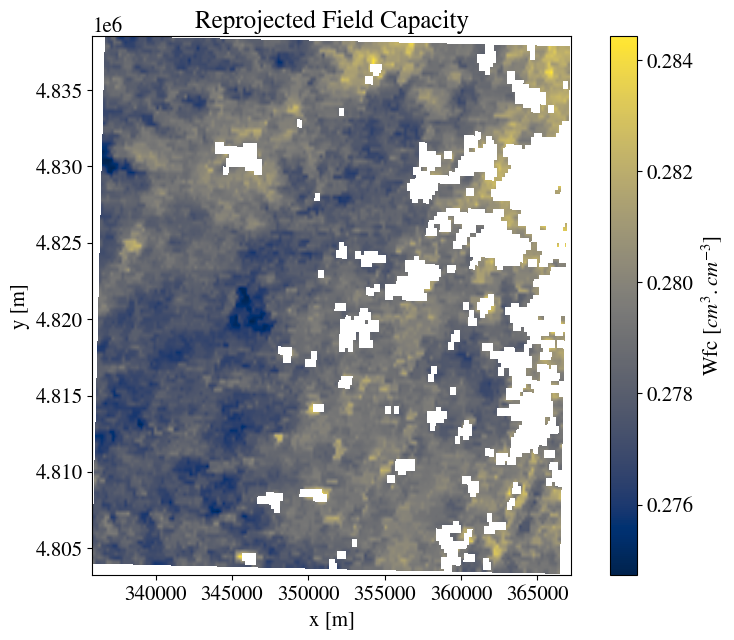

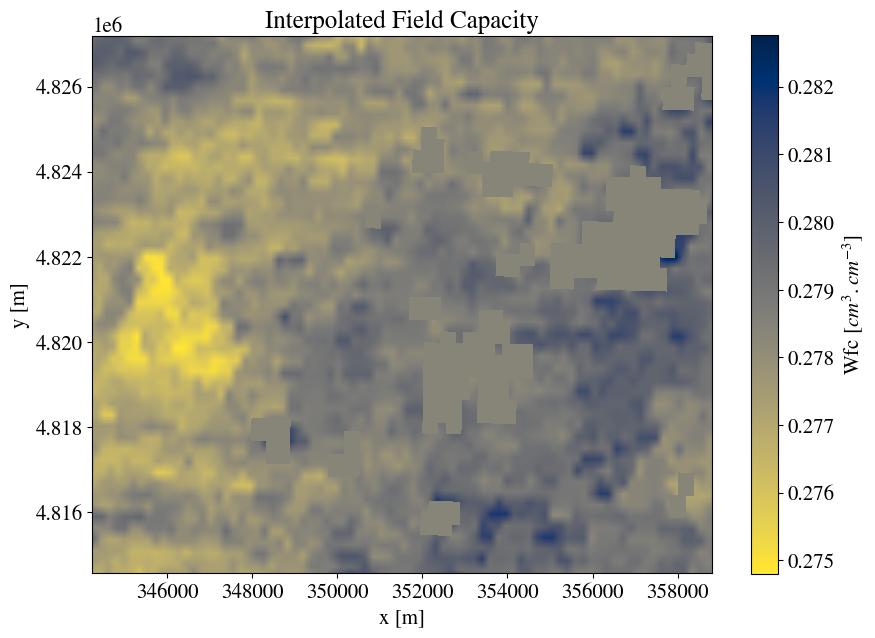

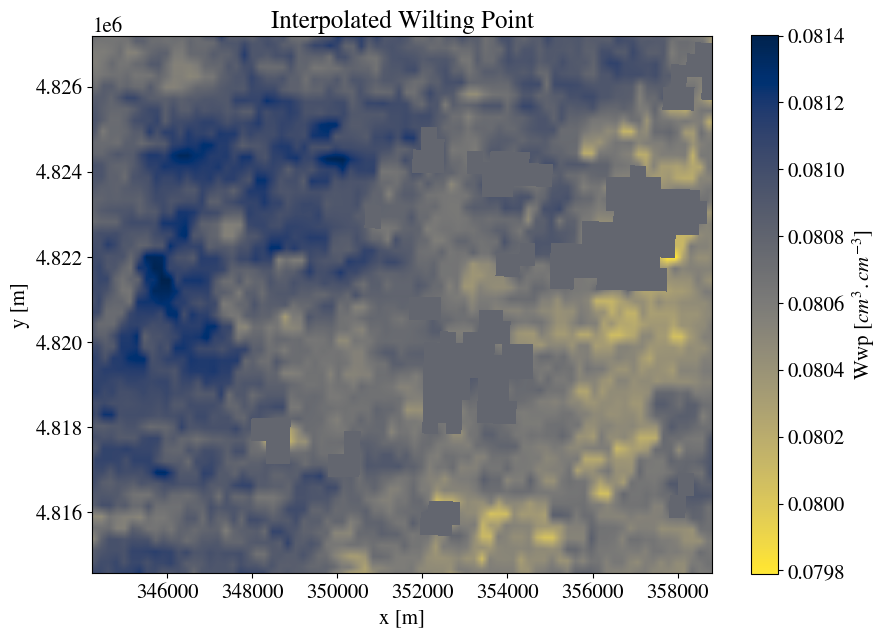

In [5]:
# Shapfile containing bounds, to clip original dataset
shapefile_bounds = config_params.shapefile_path

# Reference image to reproject on
if config_params.preferred_provider == 'copernicus':
    image_path = config_params.download_path + os.sep + 'SCIHUB'
    ndvi_path = image_path + os.sep + 'NDVI'
else:
    image_path = config_params.download_path + os.sep + 'THEIA'
    ndvi_path = image_path + os.sep + 'NDVI'
reference_image = ndvi_path + os.sep + config_params.run_name + os.sep + config_params.run_name + '_grid_reference.tif'

# Get bounds of simulation area
shapefile = gpd.read_file(shapefile_bounds)
bounds = shapefile.bounds.values[0]
bounds = np.round([bounds[0] - 0.1, bounds[1] - 0.1, bounds[2] + 0.1, bounds[3] + 0.1], 5)  # extend bounds 

# Get EPSG code
with rio.open(reference_image) as src:
    crs = src.crs

# Open reference image for interpolation
ref = xr.open_dataarray(reference_image).squeeze(dim = ['band'], drop = True)

# Reproject to reference crs after clip
soil_params_xy = soil_params.rename({'longitude': 'x','latitude': 'y'})
soil_params_xy = soil_params_xy.rio.write_crs('EPSG:4326')
soil_params_reprojected = soil_params_xy.sel(x = slice(bounds[0], bounds[2]), y = slice(bounds[3], bounds[1])).rio.reproject(crs, resolution = 10, resampling = Resampling.bilinear, nodata=np.nan)

# Change attributes
del soil_params_reprojected['x'].attrs['long_name']
soil_params_reprojected['x'].attrs['standard_name'] = 'x'
soil_params_reprojected['x'].attrs['units'] = 'm'
del soil_params_reprojected['y'].attrs['long_name']
soil_params_reprojected['y'].attrs['standard_name'] = 'y'
soil_params_reprojected['y'].attrs['units'] = 'm'

# Parameters for plot
figure_size = (10, 7)

# Plot reprojected dataset
fig = plt.figure(figsize = figure_size)
ax = fig.gca()
soil_params_reprojected.Wfc.plot.imshow(cmap = 'cividis')
ax.set_aspect('equal', 'box')
plt.title('Reprojected Field Capacity');

# Interpolate to get final dataset
soil_params_reprojected = soil_params_reprojected.interp(x = ref['x'].values, y = ref['y'].values, method = "linear")

# Fill missing values with average and change units
soil_params_reprojected['Wfc']= soil_params_reprojected.Wfc.fillna(soil_params_reprojected.Wfc.mean(dim = ['x', 'y']))
soil_params_reprojected['Wwp']= soil_params_reprojected.Wwp.fillna(soil_params_reprojected.Wwp.mean(dim = ['x', 'y']))

# Plot variables
fig = plt.figure(figsize = figure_size)
ax = fig.gca()
soil_params_reprojected.Wfc.plot.imshow(cmap = 'cividis_r')
ax.set_aspect('equal', 'box')
plt.title('Interpolated Field Capacity');

fig = plt.figure(figsize = figure_size)
ax = fig.gca()
soil_params_reprojected.Wwp.plot.imshow(cmap = 'cividis_r')
ax.set_aspect('equal', 'box')
plt.title('Interpolated Wilting Point');

# Save interpolated dataset
final_save_path = config_params.soil_path
soil_params_reprojected.to_netcdf(final_save_path, encoding = {"Wfc": {"dtype": "f4"}, "Wwp": {"dtype": "f4"}})